In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2


data = "/content/drive/MyDrive/Colab Notebooks/post-processed/post-processed"

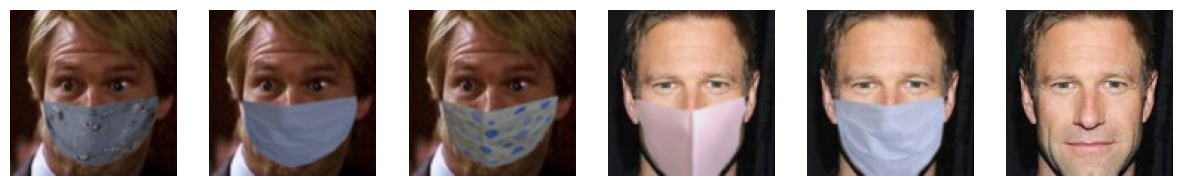

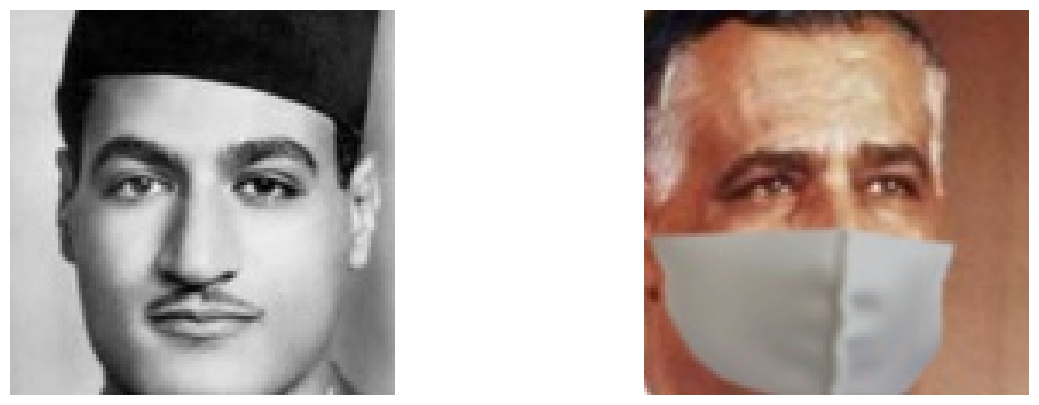

In [3]:
#vamos vizualizar a data


def plotarData(indice):
    nomes = sorted(os.listdir(data))  #diretorios
    caminhoNome = os.path.join(data, nomes[indice])  # caminho do diretorio da celebridade
    imagens = os.listdir(caminhoNome)
    lenPasta = len(imagens)

    plt.figure(figsize=(15, 5))

    for i in range(lenPasta):
        imagemCaminho = os.path.join(caminhoNome, imagens[i])  #
        img = cv2.imread(imagemCaminho)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, lenPasta, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.show()

plotarData(1)
plotarData(8)

In [14]:

#vamo criar uma função que armazena:
#1 - array com todas as imagens
#2 - array com o nome da celebridade

#infelizmente n vou conseguir fzr com todas as celebridades
def diretorioToNp(caminho):
  pastas = sorted(os.listdir(caminho))
  imagens = []
  labels = []
  contagem = 0

  for i in pastas:#iterar sobre as pastas
    arquivos = os.listdir(os.path.join(caminho, i)) #lista de arquivos de cada pasta
    tamanhoListaArq = len(arquivos)

    for x in arquivos:#iterar sobre os arquivos
      Caminhoimagem = os.path.join(os.path.join(caminho, i), x)
      imagem = cv2.imread(Caminhoimagem)
      imagem = imagem / 255.0
      imagem = cv2.resize(imagem, (224, 224)) #Add imagem ao array
      imagens.append(imagem)
      labels.append(i)

    contagem = contagem + 1
    if contagem == 200: #vamos usar apenas 200 pessoas por causa da RAM do colab
      break


  return imagens, labels

x, y = diretorioToNp(data)

In [5]:
#usaremos um algoritmo chamado siamese network
#um tipo de rede neural usada para comparar duas entradas e determinar sua similaridade. Ela possui duas sub-redes idênticas (compartilhando pesos) que extraem características
#das entradas e um mecanismo para medir a distância entre os embeddings gerados.
import random
#para isso vamos criar uma função para criar pares de dados:
def make_pairs(images, names):
    # Converter os nomes em índices numéricos únicos
    unique_names = list(set(names))  # Lista com os nomes únicos das celebridades
    name_to_index = {name: idx for idx, name in enumerate(unique_names)}  # Mapeia nome -> índice

    y = np.array([name_to_index[name] for name in names])  # Converte nomes para índices

    num_classes = len(unique_names)  # Quantidade de celebridades diferentes
    celeb_indices = [np.where(y == i)[0] for i in range(num_classes)]  # Índices organizados por celebridade

    pairs = []
    labels = []

    for idx1 in range(len(images)):
        # Par positivo (mesma celebridade)
        x1 = images[idx1]
        label1 = y[idx1]
        idx2 = random.choice(celeb_indices[label1])
        x2 = images[idx2]

        pairs.append([x1, x2])
        labels.append(0)  # Mesmo nome → rótulo 0

        # Par negativo (celebridades diferentes)
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(celeb_indices[label2])
        x2 = images[idx2]

        pairs.append([x1, x2])
        labels.append(1)  # Nomes diferentes → rótulo 1

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x, y)

In [6]:
#construindo extrator de caracteristicas:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
import keras
from keras import ops

def euclidean_distance(vects):
    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

  #resnet
base_model = ResNet50(weights="imagenet", include_top=False)
base_model.trainable = False

  # Criando o modelo de embeddings
input_image = Input(shape=(224, 224, 3))
x = base_model(input_image)
x = GlobalAveragePooling2D()(x)  # Reduz para um vetor
embedding = Dense(128, activation="relu")(x)  # Camada densa para embeddings
feature_extractor = Model(input_image, embedding, name="FeatureExtractor")

input_1 = keras.layers.Input((224, 224, 3))
input_2 = keras.layers.Input((224, 224, 3))

tower_1 = feature_extractor(input_1)
tower_2 = feature_extractor(input_2)



merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):

        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss



In [8]:
siamese.compile(loss=loss(margin=1), optimizer="Adam", metrics=["accuracy"])
siamese.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FeatureExtractor          │ (None, 128)            │     23,849,984 │ input_layer_2[0][0],   │
│ (Functional)              │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ FeatureExtractor[0][0… │
│                           │                        │                │ FeatureExtractor[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1)              │              4 │ lambda[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │              2 │ batch_normalization[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,849,990 (90.98 MB)

 Trainable params: 262,276 (1.00 MB)

 Non-trainable params: 23,587,714 (89.98 MB)

In [9]:
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]

In [10]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    batch_size=16,
    epochs=50,
)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 37s 138ms/step - accuracy: 0.4179 - loss: 0.3745
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.4533 - loss: 0.3264
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.4448 - loss: 0.3108
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.4859 - loss: 0.2943
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.4616 - loss: 0.2950
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.4684 - loss: 0.2844
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.4550 - loss: 0.2793
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.4732 - loss: 0.2701
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.4782 - loss: 0.2664
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.4678 - loss: 0.2604
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.4552 - loss: 0.2583
Epoch 12/50
108/108 ━━━━━━━━━━━━━━━

In [11]:
#agora que temos um modelo treinado, vamos:
#1 - criar um "banco de dados" com as imagens e seus respectivos vetores
#2 - criar uma função de criar pessoa no banco (extrair seu vetor e adcionar sua foto ao banco)
#3 - criar uma função de previsao, onde alg insere uma imagem e ela preve qm é a pessoa



In [31]:
import pickle
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf

# função para criar banco e adcionar os embeddings:
def criarBanco(model, x, y, db_path="celebridades_db.pkl"):
    x = tf.convert_to_tensor(x)
    embeddings = model.predict(x)
    database = {y[i]: embeddings[i] for i in range(len(y))}
    with open(db_path, "wb") as f:
        pickle.dump(database, f)
    print("Banco de dados criado e salvo com sucesso!")

#função para adicionar pessoa ao banco
def addPessoaBanco(model, imagemCaminho, label, db_path="celebridades_db.pkl"):
    image = cv2.imread(imagemCaminho)
    image = image / 255.0
    image= cv2.resize(image, (224, 224)) #Add imagem ao array

    with open(db_path, "rb") as f:
        database = pickle.load(f)
    embedding = model.predict(np.expand_dims(image, axis=0))[0]
    database[label] = embedding
    with open(db_path, "wb") as f:
        pickle.dump(database, f)
    print(f"Pessoa {label} adicionada ao banco de dados!")

#reconhecimento facial atraves do banco
def reconhecimentoFacial(model, imageCaminho, db_path="celebridades_db.pkl"):
    image = cv2.imread(imageCaminho)
    image = image / 255.0
    image= cv2.resize(image, (224, 224)) #Add imagem ao array

    with open(db_path, "rb") as f:
        database = pickle.load(f)

    embedding = model.predict(np.expand_dims(image, axis=0))[0]
    labels = list(database.keys())
    embeddings = np.array(list(database.values()))

    # Usando Nearest Neighbors para encontrar a face mais próxima
    nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
    nn.fit(embeddings)
    dist, idx = nn.kneighbors([embedding])

    recognized_label = labels[idx[0][0]] if dist[0][0] < 0.6 else "Desconhecido"
    print(f"Pessoa reconhecida: {recognized_label}")
    return recognized_label


In [15]:
# #aplicando:
# # Criando o banco de dados
criarBanco(feature_extractor, x, y)

# # Adicionando uma nova pessoa ao banco de dados

# # Reconhecendo a pessoa usando uma imagem com máscara
# masked_image = x_mascara  # Supondo que x_mascara seja a variável com a imagem da pessoa mascarada
# recognize_face(feature_extractor, masked_image)

27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step
Banco de dados criado e salvo com sucesso!


In [34]:
#add pessoa ao banco:
novaPCaminho = "/content/gansoNoDb.webp"
novaPLabel = "PH Ganso"
addPessoaBanco(feature_extractor, novaPCaminho, novaPLabel)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Pessoa PH Ganso adicionada ao banco de dados!


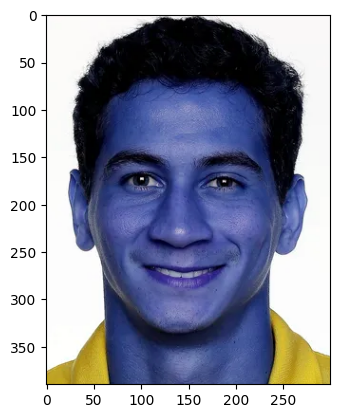

In [33]:
plt.imshow(cv2.imread("/content/gansoNoDb.webp"))

In [37]:
#reconhecimento:
# reconhecimentoCaminho = "/content/drive/MyDrive/Colab Notebooks/post-processed/post-processed/Aaron_Eckhart/Aaron_Eckhart_0001_0001.jpg"
reconhecimentoCaminho = "/content/gansoInferencia.webp"
reconhecimentoFacial(feature_extractor, reconhecimentoCaminho)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Pessoa reconhecida: PH Ganso


'PH Ganso'

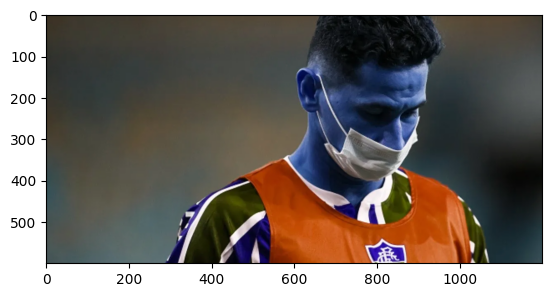

In [6]:
plt.imshow(cv2.imread("/content/gansoInferencia.webp", cv2.IMREAD_UNCHANGED))